In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad, dblquad
from scipy.special import ellipe, ellipk
from scipy.interpolate import lagrange, InterpolatedUnivariateSpline
from scipy.signal import savgol_filter

## User input

In [2]:
# Gas:
# Conversion to linear scale was made in the notebook: grav_project/NGC_5005/Gas_from_mass_surface_density.ipynb
raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
maxkpc=11.0

# Parameters
z0 = 0.93

## Density profile, outputs: radii (array), densities (array), rcut (one #), delta (one #)

In [3]:
def DensityProfile(raddens=raddens):
    mudata = np.loadtxt(raddens)     
    xdinp, ydinp = mudata.T
    rcut = xdinp[len(xdinp)-1]               # rcut is the LAST radius value (?)
    delta = rcut - xdinp[len(xdinp)-2]       # difference between the last two radius values
    
    return xdinp, ydinp, rcut, delta

#defining these output values:
# Radius
xdinp = DensityProfile()[0]
# Density
ydinp = DensityProfile()[1]
# Cutoff radius
rcut = DensityProfile()[2]
# Cutoff length
delta = DensityProfile()[3]

## Interpolation

In [4]:
def interpd(x,y):
    #return lagrange(x,y)                # Lagrange interpolation didn't work well so I used Univariate Spline
    return InterpolatedUnivariateSpline(x,y,k=4)
    
# Calculate the density values at the sampling radii
spline_rhor = interpd(xdinp,ydinp)        # define the polynomial that's calculated

radii = np.arange(0.001,11,0.1)                # Sampling radii
## Partial derivative / Smoothing

In [5]:
#radii = np.linspace(0.001,maxkpc,100)                # Sampling radii
radii = np.arange(0.001,11,0.1)                # Sampling radii
print(radii)

# Partial derivative of rho(u,z) with respect to u
# Taking the derivative of the splined polynomial (radius and density values, rho(r) or rho(u))
drho_du = spline_rhor.derivative()

# Evaluating at given radii
drho_du_values = drho_du(radii)

# Smoothing: Savitzky-Golay filter: https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter
drho_du_smooth = savgol_filter(drho_du_values, 11, 5)  # window size 11, polynomial order 6

# Spline the smoothed derivative
spline_drhor = interpd(radii,drho_du_smooth)

[1.0000e-03 1.0100e-01 2.0100e-01 3.0100e-01 4.0100e-01 5.0100e-01
 6.0100e-01 7.0100e-01 8.0100e-01 9.0100e-01 1.0010e+00 1.1010e+00
 1.2010e+00 1.3010e+00 1.4010e+00 1.5010e+00 1.6010e+00 1.7010e+00
 1.8010e+00 1.9010e+00 2.0010e+00 2.1010e+00 2.2010e+00 2.3010e+00
 2.4010e+00 2.5010e+00 2.6010e+00 2.7010e+00 2.8010e+00 2.9010e+00
 3.0010e+00 3.1010e+00 3.2010e+00 3.3010e+00 3.4010e+00 3.5010e+00
 3.6010e+00 3.7010e+00 3.8010e+00 3.9010e+00 4.0010e+00 4.1010e+00
 4.2010e+00 4.3010e+00 4.4010e+00 4.5010e+00 4.6010e+00 4.7010e+00
 4.8010e+00 4.9010e+00 5.0010e+00 5.1010e+00 5.2010e+00 5.3010e+00
 5.4010e+00 5.5010e+00 5.6010e+00 5.7010e+00 5.8010e+00 5.9010e+00
 6.0010e+00 6.1010e+00 6.2010e+00 6.3010e+00 6.4010e+00 6.5010e+00
 6.6010e+00 6.7010e+00 6.8010e+00 6.9010e+00 7.0010e+00 7.1010e+00
 7.2010e+00 7.3010e+00 7.4010e+00 7.5010e+00 7.6010e+00 7.7010e+00
 7.8010e+00 7.9010e+00 8.0010e+00 8.1010e+00 8.2010e+00 8.3010e+00
 8.4010e+00 8.5010e+00 8.6010e+00 8.7010e+00 8.8010e+00 8.9010

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


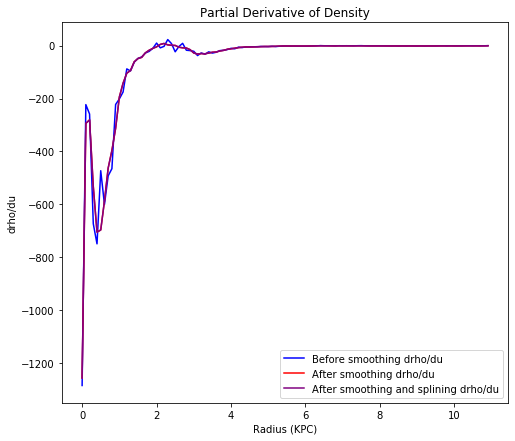

In [6]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du_values, label="Before smoothing drho/du", c="blue")
plt.plot(radii,drho_du_smooth, label="After smoothing drho/du", c="red")
plt.plot(radii,spline_drhor(radii), label="After smoothing and splining drho/du", c="purple")
plt.title("Partial Derivative of Density")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

## Functions

In [7]:
#from casertano http://articles.adsabs.harvard.edu/pdf/1983MNRAS.203..735C
# Casertano Eq 2
def drho_du(u,z,z0):
    return spline_drhor(u) * np.cosh(z / z0)**(-2)

print(drho_du(1,1,z0))

-73.01552084148702


In [8]:
# Casertano Eq 5
def px(r,u,z):
    x = (r**2 + u**2 + z**2)/(2*r*u)
    return x - np.sqrt((x**2)-1)

print(px(1,1,1))

0.3819660112501051


In [9]:
# Complete elliptic integral
def K_E(r,u,z):
    return ellipk(px(r,u,z)) - ellipe(px(r,u,z))

print(K_E(1,1,1))

0.35734399698214614


In [10]:
#constants
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  

#casertano eq 4, simplified
def integrand(r,u,z,z0,G):
    return (8 * G) * drho_du(u,z,z0) * K_E(r,u,z) * np.sqrt((u/(r * px(r,u,z))))

print(integrand(1,2,3,z0,G))

-4.872075411008798e-07


## Integration

In [11]:
# Define minimum and maximum values of radius for integration
intmin = np.min(radii)
intmax = np.max(radii)
#intmax=np.inf ????
print(intmin)
print(intmax)

0.001
10.901


In [12]:
# Reverse order of variables to setup for integration
integrand2 = lambda z,u,r,z0,G: integrand(r,u,z,z0,G)
print(integrand2(3,2,1,z0,G))

# Integrate double integral
#radialforce = lambda r: dblquad(integrand2, intmin, intmax, lambda u: intmin, lambda u: intmax, args=(r))
radialforce = lambda r,z0,G: nquad(integrand2, [[intmin,intmax], [intmin,intmax]], args=(r,z0,G))[0]
print(radialforce(1,z0,G))
radialforce = np.vectorize(radialforce)
print(radialforce(1,z0,G))

-4.872075411008798e-07
-0.009020239552613425
-0.009020239552613425


## Velocity

In [13]:
#casertano eq 6:
velocs = (-radii*radialforce(radii,z0,G))**(0.5)
scale = 5e2
velocs=velocs*scale
#velocs=[x for x in velocs if x <= 43]
#radii = np.linspace(0.001,11,len(velocs))                # Sampling radii
#velocs_smooth = savgol_filter(velocs, 11, 4)

## Comparison

In [14]:
# Gas
tracedgas = np.loadtxt("../NGC_5005/traced_data/ngc5005_gas.txt")
tracedgas_r, tracedgas_v = tracedgas.T
tracedgas_r = tracedgas_r[1:]
tracedgas_v = tracedgas_v[1:]

# Disk
traceddisk = np.loadtxt("../NGC_5005/traced_data/ngc5005_disk.txt")
traceddisk_r, traceddisk_v = traceddisk.T
traceddisk_r = traceddisk_r[1:]
traceddisk_v = traceddisk_v[1:]

## Plot

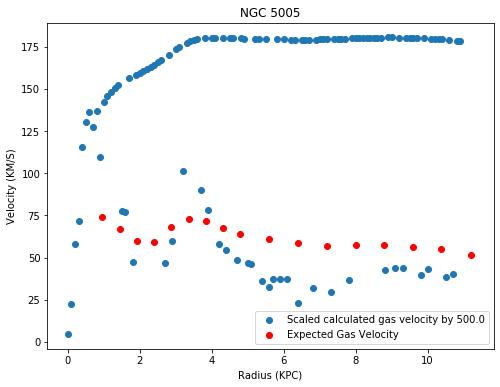

In [15]:
newscale=3
plt.figure(figsize=(8,6))             
plt.scatter(radii, newscale*np.asarray(velocs), linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
#plt.plot(radii, 1e3*velocs_smooth, linestyle='solid', label='Smoothed Gas Velocity')
plt.scatter(tracedgas_r, tracedgas_v, label='Expected Gas Velocity', c='red')
plt.axis('tight');
plt.title('NGC 5005')
plt.xlabel('Radius (KPC)', fontsize=10)
plt.ylabel('Velocity (KM/S)', fontsize=10)
#plt.xlim(0,12)
plt.legend(fontsize=10)
plt.show()